In [1]:
# Import necessary libraries
import os
import pickle
import pandas as pd
import numpy as np
from currency_converter import CurrencyConverter
from sklearn.model_selection import train_test_split
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from ast import literal_eval

In [2]:
# Search for dataset file path
for dirname, _, filenames in os.walk('.\\data'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

.\data\Car_sale_ads.csv


In [3]:
# Read dataset, display first rows and basic informations about columns
# Use literal_eval function as a converter for Features column to read values as lists not strings
df_raw = pd.read_csv('.\\data\\Car_sale_ads.csv', index_col='Index', converters={'Features': literal_eval})
df = df_raw.copy()

In [4]:
df.head()

Price Currency Condition Vehicle_brand Vehicle_model Vehicle_version  \
Index                                                                         
0      86200      PLN       New        Abarth           595             NaN   
1      43500      PLN      Used        Abarth         Other             NaN   
2      44900      PLN      Used        Abarth           500             NaN   
3      39900      PLN      Used        Abarth           500             NaN   
4      97900      PLN       New        Abarth           595             NaN   

      Vehicle_generation  Production_year  Mileage_km  Power_HP  ...  \
Index                                                            ...   
0                    NaN             2021         1.0     145.0  ...   
1                    NaN             1974     59000.0      75.0  ...   
2                    NaN             2018     52000.0     180.0  ...   
3                    NaN             2012     29000.0     160.0  ...   
4                    NaN             2021       600.0     165.0  ...   

       Transmission        Type  Doors_number  Colour Origin_country  \
Index                                                                  
0            Manual  small_cars           3.0    gray            NaN   
1            Manual       coupe           2.0  silver            NaN   
2         Automatic  small_cars           3.0  silver            NaN   
3            Manual  small_cars           3.0    gray            NaN   
4            Manual  small_cars           3.0    blue            NaN   

      First_owner  First_registration_date Offer_publication_date  \
Index                                                               
0             NaN                      NaN             04/05/2021   
1             NaN                      NaN             03/05/2021   
2             NaN                      NaN             03/05/2021   
3             NaN                      NaN             30/04/2021   
4             NaN                      NaN             30/04/2021   

                                          Offer_location  \
Index                                                      
0      ul. Jubilerska 6 - 04-190 Warszawa, Mazowiecki...   
1      kanonierska12 - 04-425 Warszawa, Rembertów (Po...   
2                       Warszawa, Mazowieckie, Białołęka   
3                                      Jaworzno, Śląskie   
4      ul. Gorzysława 9 - 61-057 Poznań, Nowe Miasto ...   

                                                Features  
Index                                                     
0                                                     []  
1                                                     []  
2      [ABS, Electric front windows, Drivers airbag, ...  
3      [ABS, Electric front windows, Drivers airbag, ...  
4      [ABS, Electrically adjustable mirrors, Passeng...  

[5 rows x 24 columns]

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 208304 entries, 0 to 208303
Data columns (total 24 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   Price                    208304 non-null  int64  
 1   Currency                 208304 non-null  object 
 2   Condition                208304 non-null  object 
 3   Vehicle_brand            208304 non-null  object 
 4   Vehicle_model            208304 non-null  object 
 5   Vehicle_version          138082 non-null  object 
 6   Vehicle_generation       147860 non-null  object 
 7   Production_year          208304 non-null  int64  
 8   Mileage_km               207321 non-null  float64
 9   Power_HP                 207661 non-null  float64
 10  Displacement_cm3         206338 non-null  float64
 11  Fuel_type                208304 non-null  object 
 12  CO2_emissions            94047 non-null   float64
 13  Drive                    193228 non-null  object 
 14  Tran

In [6]:
# Remove duplicated rows from dataset
df['Doors_number'] = df['Doors_number'].convert_dtypes()

duplicates = df.duplicated(subset=df.columns[:-1]).sum()
df = df.drop_duplicates(subset=df.columns[:-1])
print(f'{duplicates} duplicates removed.')

1707 duplicates removed.


In [7]:
# Convert price from the original currency to USD taking into account the exchange rates
# on the day of offer publication.
converter = CurrencyConverter(fallback_on_missing_rate=True)
df['Offer_publication_date'] = pd.to_datetime(df['Offer_publication_date'], dayfirst=True)
df['Price'] = df.apply(lambda x: converter.convert(x['Price'], x['Currency'],
                                                   'USD', date=x['Offer_publication_date'].date()), axis=1)

In [8]:
# Drop columns
cols_to_drop = ['Currency', 'Vehicle_version', 'Vehicle_generation', 'CO2_emissions', 'Origin_country',
                'First_owner', 'First_registration_date', 'Offer_publication_date']
df = df.drop(columns=cols_to_drop)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206597 entries, 0 to 208298
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             206597 non-null  float64
 1   Condition         206597 non-null  object 
 2   Vehicle_brand     206597 non-null  object 
 3   Vehicle_model     206597 non-null  object 
 4   Production_year   206597 non-null  int64  
 5   Mileage_km        205634 non-null  float64
 6   Power_HP          205969 non-null  float64
 7   Displacement_cm3  204703 non-null  float64
 8   Fuel_type         206597 non-null  object 
 9   Drive             191758 non-null  object 
 10  Transmission      206126 non-null  object 
 11  Type              206597 non-null  object 
 12  Doors_number      205168 non-null  Int64  
 13  Colour            206597 non-null  object 
 14  Offer_location    206597 non-null  object 
 15  Features          206597 non-null  object 
dtypes: Int64(1), float64

In [9]:
# Extract province name from Offer_location column which contains the whole offer location address
# 'unknown' value is assigned to rows without province name in Offer_location
# Save provinces to file
provinces = ('dolnośląskie', 'kujawsko-pomorskie', 'lubelskie', 'lubuskie', 'łódzkie', 'małopolskie',
             'mazowieckie', 'opolskie', 'podkarpackie', 'podlaskie', 'pomorskie', 'śląskie',
             'świętokrzyskie', 'warmińsko-mazurskie', 'wielkopolskie', 'zachodniopomorskie')

with open('.\\web_app_data\\Offer_location.pkl', 'wb') as file:
    pickle.dump(provinces, file)

def find_province(x):
    found = [word.lower().strip('-/:,.; ') for word in x.split()
             if word.lower().strip('-/:,.; ') in provinces]
    return found[0] if found else 'unknown'
    
df['Offer_location'] = df['Offer_location'].apply(find_province)
df['Offer_location'].value_counts()

unknown                29675
mazowieckie            28769
wielkopolskie          24356
śląskie                23470
małopolskie            16106
dolnośląskie           12471
łódzkie                10174
pomorskie               9635
kujawsko-pomorskie      9297
lubelskie               7608
podkarpackie            6625
świętokrzyskie          5934
zachodniopomorskie      5762
lubuskie                5204
warmińsko-mazurskie     4769
opolskie                3619
podlaskie               3123
Name: Offer_location, dtype: int64

In [10]:
# Drop rows with rare vehicle brands and save unique brands to file
brands_count = df['Vehicle_brand'].value_counts()
brands = brands_count[brands_count >= 10].index.tolist()
df = df[df['Vehicle_brand'].isin(brands)]

with open('.\\web_app_data\\Vehicle_brand.pkl', 'wb') as file:
    pickle.dump(brands, file)

In [11]:
# Extract unique car models for each brand and save it to file
models = dict()
for brand in brands:
    temp = df[df['Vehicle_brand'] == brand]
    brand_models = temp['Vehicle_model'].value_counts().index.tolist()
    models[brand] = brand_models

with open('.\\web_app_data\\Vehicle_model.pkl', 'wb') as file:
    pickle.dump(models, file)

In [12]:
# Extract and save to file additional cars features
additional_features = []
for _, features in df['Features'].iteritems():
    for feature in features:
        if not feature in additional_features:
            additional_features.append(feature)

with open('.\\web_app_data\\Features.pkl', 'wb') as file:
    pickle.dump(additional_features, file)
    
additional_features

['ABS',
 'Electric front windows',
 'Drivers airbag',
 'Power steering',
 'ASR (traction control)',
 'Rear view camera',
 'Heated side mirrors',
 'CD',
 'Electrically adjustable mirrors',
 'Passengers airbag',
 'Alarm',
 'Bluetooth',
 'Automatic air conditioning',
 'Airbag protecting the knees',
 'Central locking',
 'Immobilizer',
 'Factory radio',
 'Alloy wheels',
 'Rain sensor',
 'On-board computer',
 'Multifunction steering wheel',
 'AUX socket',
 'Xenon lights',
 'USB socket',
 'MP3',
 'ESP(stabilization of the track)',
 'Front side airbags',
 'Rear parking sensors',
 'Isofix',
 'Air curtains',
 'Tinted windows',
 'Daytime running lights',
 'Rear side airbags',
 'Fog lights',
 'Twilight sensor',
 'GPS navigation',
 'LED lights',
 'Manual air conditioning',
 'Start-Stop system',
 'Electrochromic rear view mirror',
 'Velor upholstery',
 'Electrochromic side mirrors',
 'SD socket',
 'Dual zone air conditioning',
 'Adjustable suspension',
 'Panoramic roof',
 'Sunroof',
 'Front parking 

In [13]:
# Extract and save to file unique values of other categorical columns:
cat_cols = ['Condition', 'Fuel_type', 'Drive', 'Transmission', 'Type', 'Colour']

for col in cat_cols:
    values = df[col].value_counts().index.tolist()
    with open(f'.\\web_app_data\\{col}.pkl', 'wb') as file:
        pickle.dump(values, file)

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 206462 entries, 0 to 208291
Data columns (total 16 columns):
 #   Column            Non-Null Count   Dtype  
---  ------            --------------   -----  
 0   Price             206462 non-null  float64
 1   Condition         206462 non-null  object 
 2   Vehicle_brand     206462 non-null  object 
 3   Vehicle_model     206462 non-null  object 
 4   Production_year   206462 non-null  int64  
 5   Mileage_km        205499 non-null  float64
 6   Power_HP          205837 non-null  float64
 7   Displacement_cm3  204571 non-null  float64
 8   Fuel_type         206462 non-null  object 
 9   Drive             191678 non-null  object 
 10  Transmission      205993 non-null  object 
 11  Type              206462 non-null  object 
 12  Doors_number      205036 non-null  Int64  
 13  Colour            206462 non-null  object 
 14  Offer_location    206462 non-null  object 
 15  Features          206462 non-null  object 
dtypes: Int64(1), float64

In [15]:
# Show minimum and maximum values of numerical columns
num_cols = ['Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3', 'Doors_number']

for col in num_cols:
    min_ = df[col].min()
    max_ = df[col].max()
    print(f'{col} | Values from {min_} to {max_}')

Production_year | Values from 1915 to 2021
Mileage_km | Values from 1.0 to 1111111111.0
Power_HP | Values from 1.0 to 1398.0
Displacement_cm3 | Values from 400.0 to 8400.0
Doors_number | Values from 1 to 55


In [16]:
# Split dataset to train and test sets
y = df['Price']
X = df.drop(columns=['Price'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f'Train set size: {len(X_train)}')
print(f'Test set size: {len(X_test)}')

Train set size: 165169
Test set size: 41293


In [17]:
# Define custom column transformer for converting the least frequent categorical feature values
# to one common value to reduce the number of columns after dummy encoding
# Missing values fill with 'Unknown'
# The 'thresh' parameter specifies the minimum number of occurrences of the feature value
# to be included after the transformation

class CarsTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self, col_name, thresh=10):
        self.values_dict = dict()
        self.thresh = thresh
        self.col_name = col_name
    
    def fit(self, X):
        for _, val in X[self.col_name].iteritems():
            if not val in self.values_dict.keys():
                self.values_dict[val] = 1
            else:
                self.values_dict[val] += 1
        self.most_popular_values = [val for val, count in self.values_dict.items() if count >= self.thresh]
        return self
    
    @staticmethod
    def check_value(value, most_popular_values):
        if pd.isna(value):
            return 'Unknown'
        else:
            return value if value in most_popular_values else 'Other'
    
    def transform(self, X):
        X[self.col_name] = X[self.col_name].apply(CarsTransformer.check_value,
                                                  args=(self.most_popular_values,))
        return X

In [18]:
# Define custom column transformer for extracting additional car features and dummy encoding

class CarFeaturesTransformer(BaseEstimator, TransformerMixin):
    
    def __init__(self):
        self.features_list = list()
    
    def fit(self, X, col_name='Features'):
        for _, features in X[col_name].iteritems():
            for feature in features:
                feature = feature.lower().replace(' ', '_').replace('-', '_')
                if not feature in self.features_list:
                    self.features_list.append(feature)
        return self
    
    @staticmethod
    def check_feature(x, new_feature):
        sample_features = [feature.lower().replace(' ', '_').replace('-', '_') for feature in x]
        return 1 if new_feature in sample_features else 0
    
    def transform(self, X, col_name='Features'):
        X_new = X.copy()
        for new_feature in self.features_list:
            X_new[new_feature] = X_new[col_name].apply(CarFeaturesTransformer.check_feature,
                                                       args=(new_feature,))
        return X_new.drop(columns=[col_name])

In [19]:
# Prepare lists of categorical and numerical columns before performing preprocessing
numerical = X_train.select_dtypes(include=np.number).columns.tolist()
categorical = X_train.select_dtypes(include='object').columns.tolist()
categorical.remove('Features')
numerical.remove('Doors_number')
print(f'Numerical: {numerical}')
print(f'Categorical: {categorical}')

Numerical: ['Production_year', 'Mileage_km', 'Power_HP', 'Displacement_cm3']
Categorical: ['Condition', 'Vehicle_brand', 'Vehicle_model', 'Fuel_type', 'Drive', 'Transmission', 'Type', 'Colour', 'Offer_location']


In [20]:
# Display number of NULL values in the remaining columns
X_train.isnull().sum()

Condition               0
Vehicle_brand           0
Vehicle_model           0
Production_year         0
Mileage_km            754
Power_HP              504
Displacement_cm3     1520
Fuel_type               0
Drive               11783
Transmission          370
Type                    0
Doors_number         1133
Colour                  0
Offer_location          0
Features                0
dtype: int64

In [21]:
# Define separate transformers for different columns:
# for categorical features impute 'unknown' for all missing values and use dummy encoding
# for numerical features use KNNImputer to fill missing values and perform scaling
# to impute missing values in Doors_number use median
# use CarsTransformer to remove infrequent values and fill missing values in Vahicle_brand, Vahicle_model
# use CarFeaturesTransformer to extract end encode additional cars features

cat_pipe = Pipeline([('imputer', SimpleImputer(strategy='constant', fill_value='unknown')),
                     ('encoder', OneHotEncoder(drop='if_binary'))])

num_pipe = Pipeline([('imputer', KNNImputer(n_neighbors=5)),
                    ('scaler', StandardScaler())])

col_transformer = ColumnTransformer([('cat_pipe', cat_pipe, categorical),
                                    ('num_pipe', num_pipe, numerical),
                                    ('doors_imputer', SimpleImputer(strategy='median'), ['Doors_number'])],
                                    remainder='passthrough')

preprocessor = Pipeline([('brand_transformer', CarsTransformer(col_name='Vehicle_brand', thresh=10)),
                         ('model_transformer', CarsTransformer(col_name='Vehicle_model', thresh=10)),
                         ('features_transformer', CarFeaturesTransformer()),
                         ('col_transformer', col_transformer)])

In [22]:
# Prepare train set and save fitted preprocessor to file
X_train_prep = preprocessor.fit_transform(X_train)

with open('.\\web_app_data\\preprocessor.pkl', 'wb') as file:
    pickle.dump(preprocessor, file)

print(f'Prepared data shape: {X_train_prep.shape}')

Prepared data shape: (165169, 859)


In [32]:
# Import libraries 
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from xgboost import XGBRegressor

In [24]:
# Search for an optimal number of trees using early stopping
X_train2, X_eval, y_train2, y_eval = train_test_split(X_train_prep, y_train, test_size=0.2,
                                                      random_state=42)
eval_set = [(X_train2, y_train2), (X_eval, y_eval)]

model = XGBRegressor(n_estimators=1000, learning_rate=0.1, max_depth=8, subsample=0.8,
                     colsample_bytree=0.8)
model.fit(X_train2, y_train2, eval_metric='rmse', eval_set=eval_set,
          verbose=True, early_stopping_rounds=50)

[0]	validation_0-rmse:26186.89453	validation_1-rmse:27798.33594
[1]	validation_0-rmse:24034.81836	validation_1-rmse:25686.84180
[2]	validation_0-rmse:21963.57031	validation_1-rmse:23750.11328
[3]	validation_0-rmse:20103.78320	validation_1-rmse:22040.90039
[4]	validation_0-rmse:18418.66992	validation_1-rmse:20466.50586
[5]	validation_0-rmse:17042.06250	validation_1-rmse:19204.97852
[6]	validation_0-rmse:15741.73438	validation_1-rmse:17997.73438
[7]	validation_0-rmse:14563.07227	validation_1-rmse:16930.09570
[8]	validation_0-rmse:13475.36523	validation_1-rmse:15988.57910
[9]	validation_0-rmse:12562.61621	validation_1-rmse:15179.11816
[10]	validation_0-rmse:11710.39160	validation_1-rmse:14511.78809
[11]	validation_0-rmse:10966.69922	validation_1-rmse:13910.99609
[12]	validation_0-rmse:10295.33594	validation_1-rmse:13431.40820
[13]	validation_0-rmse:9694.48535	validation_1-rmse:12978.76953
[14]	validation_0-rmse:9203.47168	validation_1-rmse:12575.89453
[15]	validation_0-rmse:8773.61621	val

[128]	validation_0-rmse:4331.36377	validation_1-rmse:9824.94531
[129]	validation_0-rmse:4328.25732	validation_1-rmse:9824.57422
[130]	validation_0-rmse:4324.92139	validation_1-rmse:9822.03711
[131]	validation_0-rmse:4313.63672	validation_1-rmse:9820.02930
[132]	validation_0-rmse:4308.94287	validation_1-rmse:9819.18652
[133]	validation_0-rmse:4307.19141	validation_1-rmse:9818.02051
[134]	validation_0-rmse:4302.54834	validation_1-rmse:9815.71875
[135]	validation_0-rmse:4295.74512	validation_1-rmse:9814.54883
[136]	validation_0-rmse:4290.39111	validation_1-rmse:9812.77734
[137]	validation_0-rmse:4285.46387	validation_1-rmse:9813.04492
[138]	validation_0-rmse:4281.16602	validation_1-rmse:9811.92578
[139]	validation_0-rmse:4277.06885	validation_1-rmse:9811.31934
[140]	validation_0-rmse:4273.11621	validation_1-rmse:9810.87207
[141]	validation_0-rmse:4270.15723	validation_1-rmse:9806.33691
[142]	validation_0-rmse:4266.47266	validation_1-rmse:9805.51758
[143]	validation_0-rmse:4263.26074	valid

[257]	validation_0-rmse:3680.70752	validation_1-rmse:9739.34082
[258]	validation_0-rmse:3677.47217	validation_1-rmse:9738.66113
[259]	validation_0-rmse:3675.53809	validation_1-rmse:9737.94141
[260]	validation_0-rmse:3669.91992	validation_1-rmse:9737.37793
[261]	validation_0-rmse:3669.05420	validation_1-rmse:9737.41992
[262]	validation_0-rmse:3667.79688	validation_1-rmse:9738.07910
[263]	validation_0-rmse:3641.24390	validation_1-rmse:9764.72168
[264]	validation_0-rmse:3639.39282	validation_1-rmse:9761.91894
[265]	validation_0-rmse:3634.03369	validation_1-rmse:9761.18066
[266]	validation_0-rmse:3630.94336	validation_1-rmse:9760.43164
[267]	validation_0-rmse:3628.37964	validation_1-rmse:9760.25781
[268]	validation_0-rmse:3625.29932	validation_1-rmse:9764.45019
[269]	validation_0-rmse:3620.56201	validation_1-rmse:9763.57617
[270]	validation_0-rmse:3619.62598	validation_1-rmse:9763.33106
[271]	validation_0-rmse:3618.13794	validation_1-rmse:9763.42871
[272]	validation_0-rmse:3612.08252	valid

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.8, enable_categorical=False,
             gamma=0, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.1, max_delta_step=0,
             max_depth=8, min_child_weight=1, missing=nan,
             monotone_constraints='()', n_estimators=1000, n_jobs=12,
             num_parallel_tree=1, predictor='auto', random_state=0, reg_alpha=0,
             reg_lambda=1, scale_pos_weight=1, subsample=0.8,
             tree_method='exact', validate_parameters=1, verbosity=None)

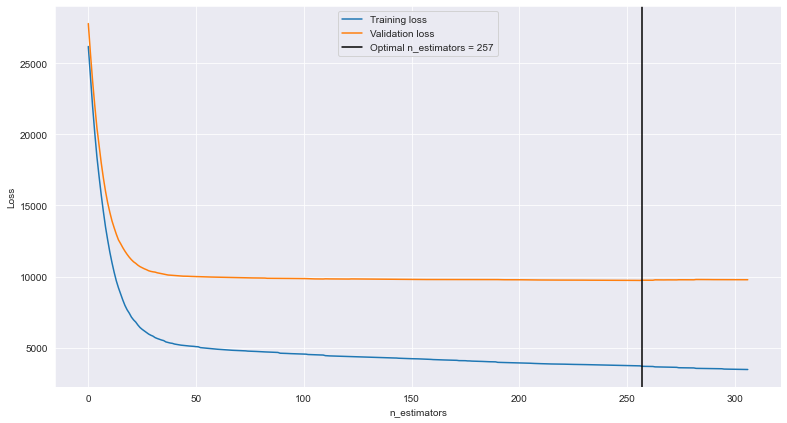

In [25]:
# Show learning curve and optimal value for n_estimators hyperparameter
results = model.evals_result()
best_n = model.best_ntree_limit

sns.set_style('darkgrid')
plt.figure(figsize=(13, 7))
plt.plot(results["validation_0"]["rmse"], label="Training loss")
plt.plot(results["validation_1"]["rmse"], label="Validation loss")
plt.axvline(best_n, color="black", label=f'Optimal n_estimators = {best_n}')
plt.xlabel("n_estimators")
plt.ylabel("Loss")
plt.legend()
plt.show()

In [26]:
# Use grid search to find the optimal depth of trees
params = {'max_depth': np.arange(6, 15, 1)}

model = XGBRegressor(n_estimators=best_n, learning_rate=0.1, max_depth=8, subsample=0.8,
                     colsample_bytree=0.8)
grid_search = GridSearchCV(estimator=model, param_grid=params, n_jobs=-1,
                           scoring='neg_mean_squared_error', cv=5, verbose=1)
grid_search.fit(X_train_prep, y_train)
print(f'Best params: {grid_search.best_params_}')

Fitting 5 folds for each of 9 candidates, totalling 45 fits
Best params: {'max_depth': 12}


In [27]:
# Tune hyperparameters that allow avoiding overfitting using RandomizedSearchCV
params = {'learning_rate': [0.001, 0.003, 0.01, 0.03, 0.1, 0.3],
          'subsample': np.arange(0.6, 0.85, 0.05),
          'colsample_bytree': np.arange(0.6, 0.85, 0.05),
          'min_child_weight': np.arange(1, 6, 2),
          'gamma': np.arange(0, 1, 0.1)} 

model = grid_search.best_estimator_
random_search = RandomizedSearchCV(estimator=model, param_distributions=params, n_iter=50, n_jobs=-1,
                                   scoring='neg_mean_squared_error', cv=5, verbose=1)
random_search.fit(X_train_prep, y_train)
print(f'Best params: {random_search.best_params_}')

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best params: {'subsample': 0.65, 'min_child_weight': 3, 'learning_rate': 0.03, 'gamma': 0.1, 'colsample_bytree': 0.65}


In [28]:
# Extract and save model to file
model = random_search.best_estimator_
with open('.\\web_app_data\\simplified_model.pkl', 'wb') as file:
    pickle.dump(model, file)

In [29]:
# Prepare test set
X_test_prep = preprocessor.transform(X_test)
print(f'Prepared test data shape: {X_test_prep.shape}')

Prepared test data shape: (41293, 859)


In [30]:
# Use model to predict prices on test set and evaluate it using RMSE and R2 score
y_pred = model.predict(X_test_prep)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'RMSE score on test set: {rmse}')
print(f'R2 score on test set: {r2}')

RMSE score on test set: 6078.577461916377
R2 score on test set: 0.9260372320359427


In [33]:
# Calculate prediction error and show comparison of predictions and actual prices on scatter plot
results = pd.DataFrame(data={'Predicted_price': y_pred,
                             'Actual_price': y_test.values,
                             'Vehicle_brand': X_test['Vehicle_brand'].values})
results['Error'] = results['Actual_price'] - results['Predicted_price']

x = y = [0, results['Actual_price'].max()]
fig = px.scatter(results, x='Actual_price', y='Predicted_price', color='Vehicle_brand', opacity=0.6,
                 labels={'Actual_price': 'Actual price (USD)', 'Predicted_price': 'Predicted price (USD)'})
fig.add_trace(go.Scatter(x=x, y=y, mode="lines", line=go.scatter.Line(color="red", width=4),
                         showlegend=False))
fig.update_layout(
    title={'text': f'RMSE = {rmse:.3f}    R2 = {r2:.3f}', 'x':0.5})
fig.show()

In [34]:
# Plot histogram of prediction errors
fig = px.histogram(results, x='Error', range_x=(-30000, 30000))
fig.update_layout(title={'text': 'Histogram of prediction errors', 'x': 0.5},
                  yaxis_title='Frequency',
                  xaxis_title='Price prediction error (USD)')
fig.show()